# *Coronary Heart Disease Prediction Based on Age, Serum Cholesterol, Maximum Heart Rate Achieved, Resting Blood Pressure, and ST Depression (oldpeak).*

### Introduction
- The dataset that our group focuses on is the Coronary Artery Heart Disease data which records 14 attributes of patients in four regions: Cleveland, Hungary, Switzerland, and VA Long Beach. The attributes include age, stage of heart disease, blood pressure, and more.
- For our project, we will be focusing on the predictive question, *"Can we predict the likelihood of Coronary Artery Heart disease in Cleveland patients based on their age, serum cholesterol, maximum heart rate achieved, resting blood pressure, and ST depression (oldpeak)?"*

- We will aim to produce an accurate K-NN classification model that uses five predictor variables that can help us predict whether a patient has heart disease.

- In our analysis for the dataset, we picked Cleveland as the region for our main focus because different regions can have variations in the chances of getting and factors that cause heart disease. We excluded categorical variables other than the heart_disease column (the num column in the original dataset) because they cannot be used for predicting heart disease in classification. We chose age and cholesterol because they are the same predictor variables that the creators of the Heart Disease dataset used in their paper, and they are also good indicators for Coronary Artery Heart disease (Detrano, 1989). From research, we also know that during a study of 2544 people that went through coronary angiography, “cholesterol levels were associated with an increase in coronary artery occlusion”. This is another reason cholesterol is chosen. Also, as people age, the heart muscle becomes stiffer and less efficient in pumping blood (Strait, 2012). Therefore, age is an important factor for predicting heart disease. We also chose to use resting blood pressure (trestbps), maximum heart rate achieved (thalch), and ST depression caused by activity compared to rest (oldpeak). Although they were not used as predictors by the creators of the dataset for analysis, and were only used for routine test data collection (Detrano, 1989), we believe that with these variables with relation to heart, our classification model may be more accurate for predicting heart disease. With only two predictor variables of age and cholesterol, it may not be enough for classifying heart disease.

- Also, the association between heart disease and cholesterol “held only for the younger men”, (Jacobson, 1992), meaning that as age increases, cholesterol levels become more insignificant in predicting coronary artery heart disease. This is why we need more predictor variables that give our model more information to predict coronary artery heart disease. From the scatterplot matrix in the next section, it can be seen that all five predictors have some correlation with the patients with heart disease present and absent. Therefore, it is a good idea to use these five variables to increase our model’s accuracy.


In [17]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(GGally)
library(repr)
options(repr.matrix.max.rows = 6)

In [18]:
set.seed(1234)
url <- "https://raw.githubusercontent.com/Jessieec/Group-Proposal/main/heart_disease_uci.csv"
heart_data <- read_csv(url)
print("Heart Disease Data Table")
heart_data

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Heart Disease Data Table"


id  age sex  dataset       cp              trestbps chol fbs  
1   1   63  Male Cleveland     typical angina  145      233   TRUE
2   2   67  Male Cleveland     asymptomatic    160      286  FALSE
3   3   67  Male Cleveland     asymptomatic    120      229  FALSE
⋮   ⋮   ⋮   ⋮    ⋮             ⋮               ⋮        ⋮    ⋮    
918 918 55  Male VA Long Beach asymptomatic    122      223   TRUE
919 919 58  Male VA Long Beach asymptomatic     NA      385   TRUE
920 920 62  Male VA Long Beach atypical angina 120      254  FALSE
    restecg          thalch exang oldpeak slope       ca thal              num
1   lv hypertrophy   150    FALSE 2.3     downsloping 0  fixed defect      0  
2   lv hypertrophy   108     TRUE 1.5     flat        3  normal            2  
3   lv hypertrophy   129     TRUE 2.6     flat        2  reversable defect 1  
⋮   ⋮                ⋮      ⋮     ⋮       ⋮           ⋮  ⋮                 ⋮  
918 st-t abnormality 100    FALSE  0      NA          NA fixed defect      2  
919 lv hypertrophy    NA       NA NA      NA          NA NA                0  
920 lv hypertrophy    93     TRUE  0      NA          NA NA                1

### *Preliminary exploratory data analysis*

In [19]:
set.seed(1234)
heart_data_wrangled <- heart_data |>
    select(age, dataset, trestbps, chol, oldpeak, thalch, num) |>
    rename(region = dataset, heart_disease = num) |>
    filter(region == "Cleveland") |>
    mutate(heart_disease = as_factor(heart_disease)) |>
    mutate(heart_disease = fct_recode(heart_disease, "absent" = "0", "present" = "1", "present" = "2", "present" = "3", "present" = "4"))
    print("Heart Disease Wrangled Data Table")
    
heart_data_wrangled

[1] "Heart Disease Wrangled Data Table"


age region    trestbps chol oldpeak thalch heart_disease
1   63  Cleveland 145      233  2.3     150    absent       
2   67  Cleveland 160      286  1.5     108    present      
3   67  Cleveland 120      229  2.6     129    present      
⋮   ⋮   ⋮         ⋮        ⋮    ⋮       ⋮      ⋮            
302 57  Cleveland 130      236  0       174    present      
303 38  Cleveland 138      175  0       173    absent       
304 28  Cleveland 130      132  0       185    absent

In [20]:
# mean of selected predictors
heart_data_mean <- summarize(heart_data_training, 
                             age_mean = mean(age),
                             chol_mean = mean(chol), 
                             trestbps_mean = mean(trestbps),
                            oldpeak_mean = mean(oldpeak),
                            thalch_mean = mean(thalch, na.rm = TRUE)) |>
                    pivot_longer(cols = age_mean:thalch_mean,
                                 names_to = "variables",
                                 values_to = "mean")
print("Mean of Predictors")
heart_data_mean

# number of observations for each class
heart_data_observations <- group_by(heart_data_training, heart_disease) |>
    summarize(count = n())
print("Count of Classes")
heart_data_observations

# rows with missing data
heart_data_missing <- filter(heart_data_training, is.na(thalch) & is.na(trestbps) & is.na(chol) & is.na(heart_disease)) |>
    count()
print("Count of NA Values")
heart_data_missing

[1] "Mean of Predictors"


variables     mean      
1 age_mean       54.806167
2 chol_mean     247.392070
3 trestbps_mean 131.731278
4 oldpeak_mean    1.035683
5 thalch_mean   149.674009

[1] "Count of Classes"


heart_disease count
1 absent        123  
2 present       104

[1] "Count of NA Values"


n
1 0

- We have summarized our training data into 3 tables. One is for the mean of each of the variables. One is for the count of each of the stages. Since our count for absent and present is similar, we can continue making the model. If one variable had much more counts than the other, then our prediction could be high if our model was good at predicting only one of the variables but not good at predicting the other variable. We do not need to worry about missing data because our missing data count is 0 in our training data. 

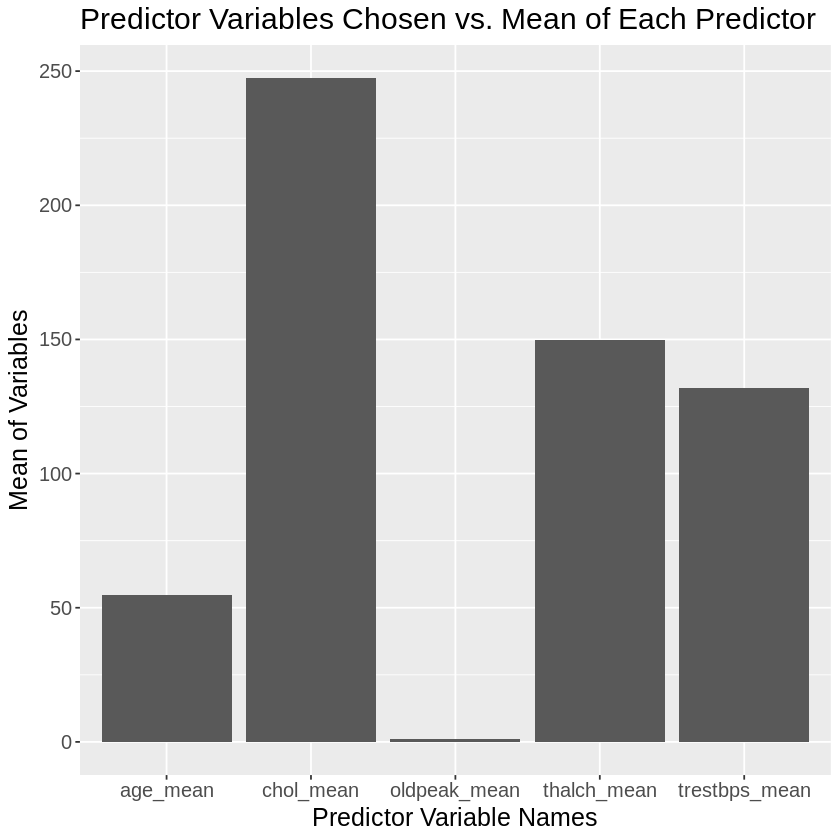

In [21]:
#graph for Mean Data
options(repr.plot.width = 7, repr.plot.height = 7)
heart_data_mean_plot <- heart_data_mean |>
    ggplot(aes(x = variables, y = mean)) +
    geom_bar(stat = "identity") +
    labs(x = "Predictor Variable Names", y = "Mean of Variables") +
    ggtitle("Predictor Variables Chosen vs. Mean of Each Predictor") +
    theme(text = element_text(size = 15))
heart_data_mean_plot

#### *Note About Oldpeak on the Mean Bar Chart:*
- Since we will be scaling the data later on in our analysis, the oldpeak value being comparably smaller will not be an issue.

### Methods & Results
- We will train our model to use K-NN classification to classify the absence, and presence of heart disease using our five predictors.
  
- First, we will use a scatterplot matrix, with different colors representing the absent and present classes, to visualize the relation between predictors with each other and with the categorical variable that we want to use to predict the data. These data used are the scaled data.

- Then, we will use cross-validation with the training data to help us determine the best K-value. We will choose v = 5 folds for our analysis. To determine the best k neighbors value, we will look at the visualization of the neighbors vs. estimated accuracy graph generated, choosing the k neighbors value with the highest accuracy to help us get better accuracy for our model later.
  
- With the K-value chosen, we will create the K-NN model by setting the mode to “classification” and the engine to “kknn”. Then, we can use workflow to fit the model to the training data.
  
- We will use the model we created by the training data to reclassify the testing data. Then, by dividing the number of correct predictions by the total number of predictions, we can determine the accuracy of our model for the testing data.
  
- We will also determine the precision and recall of our model, which can help us see how many observations (data points) are actually positive or are identified as positive for the testing data.
  
- We will draw two other scatterplot matrices, one graph will show the predicted diagnosis and classification for observations of the testing data, and the other will show the actual diagnosis and classification for observations of the testing data.
  
- All these steps above will help us answer our predictive question of whether our model is doing a good job in predicting heart disease through the 5 predictors.


In [22]:
#scale the data
set.seed(1234)
recipe <- recipe(heart_disease ~ age + chol + trestbps + thalch + oldpeak, data = heart_data_wrangled) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

heart_disease_scaled <- recipe |>  
                            prep() |> 
                            bake(heart_data_wrangled)
print("Heart Disease Scaled")
heart_disease_scaled

[1] "Heart Disease Scaled"


age        chol       trestbps   thalch      oldpeak    heart_disease
1   0.945113   -0.2555408  0.7578299  0.01205184 1.0888487  absent       
2   1.382259    0.7615721  1.6115117 -1.81982842 0.3996035  present      
3   1.382259   -0.3323040 -0.6649732 -0.90388829 1.3473157  present      
⋮   ⋮          ⋮          ⋮          ⋮           ⋮          ⋮            
302  0.2893937 -0.1979683 -0.095852  1.058841    -0.8927312 present      
303 -1.7870509 -1.3686076  0.359445  1.015224    -0.8927312 absent       
304 -2.8799164 -2.1938124 -0.095852  1.538619    -0.8927312 absent

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


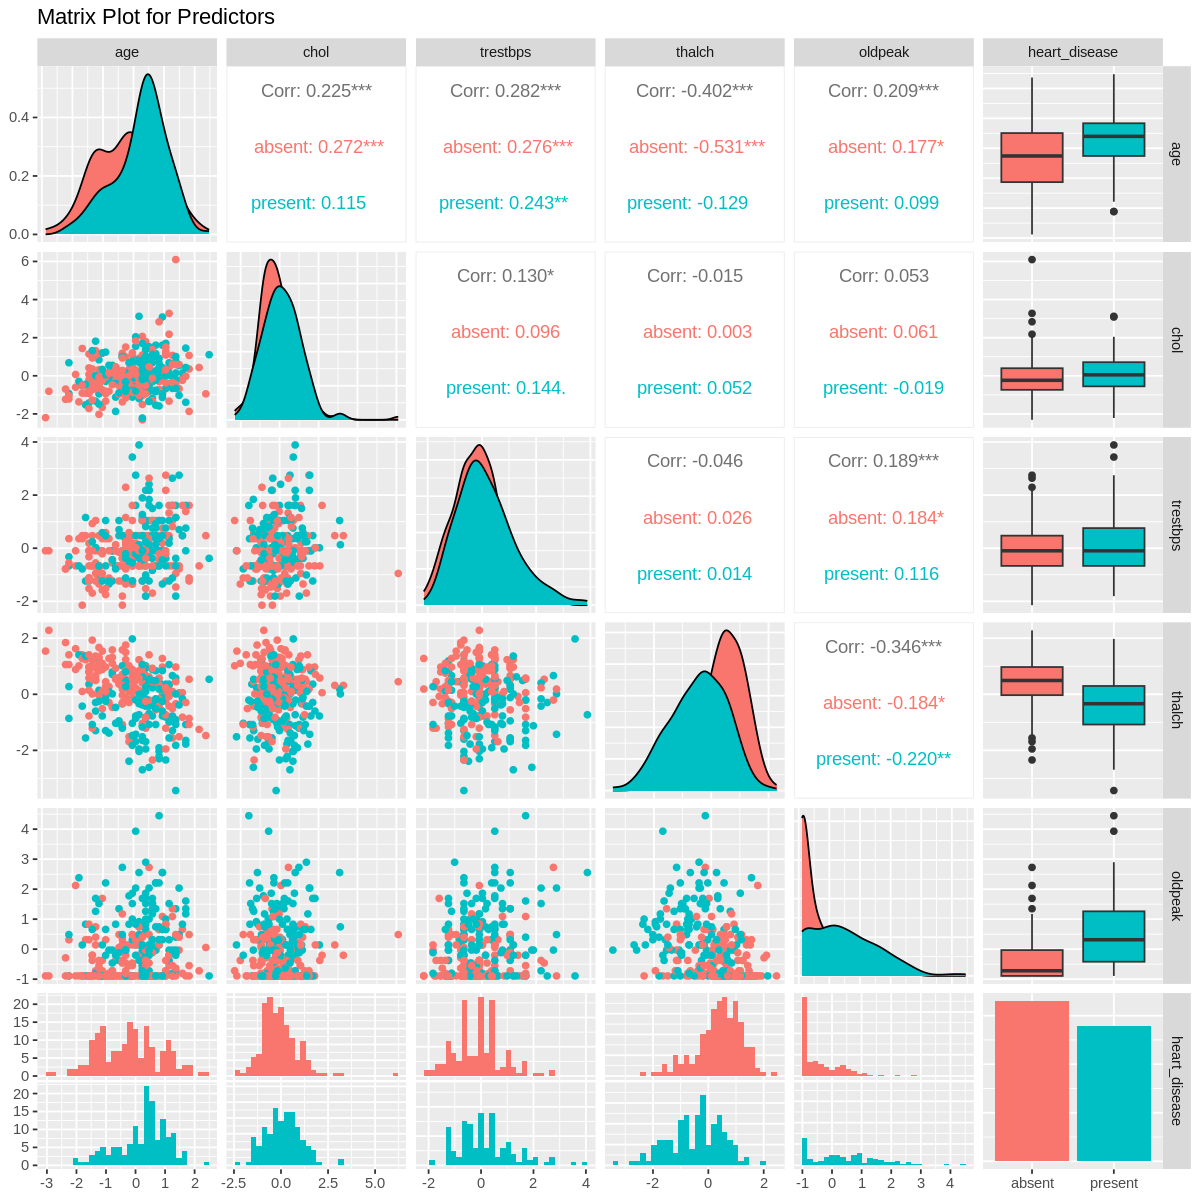

In [23]:
#graph for Age vs. Stage of Heart Disease
options(repr.plot.width = 10, repr.plot.height = 10)
Heart_Disease_Predictors_Plot <- heart_disease_scaled |> select(age:heart_disease) |>
     ggpairs(mapping = aes(color = heart_disease)) +
    ggtitle("Matrix Plot for Predictors")
Heart_Disease_Predictors_Plot

- From each of the five predictors plotted against each other, we can see that there is a slight concentration of data points that separates patients with heart disease (present) and patients without heart disease (absent). For example, there are areas on each plot with more concentration of blue points (present) than red points (absent). This means that the five predictors all have correlations to heart disease’s absence and presence.
  
- However, the groups are not too distinct, and many of the scatter plots shown in the matrix plot have groups of red and blue points mixed. This means that we may not be able to get a high accuracy because the k-nn classification model classifies points based on the closest neighboring points. Without a clear separation between groups, the neighboring points chosen may involve equally distributed amounts of blue and red points. This will cause a potentially inaccurate classification for new data points or patients.

In [24]:
#training data
set.seed(1234)
heart_data_split <- initial_split(heart_data_wrangled, prop = 0.75, strata = heart_disease)
heart_data_training <- training(heart_data_split)
heart_data_testing <- testing(heart_data_split)
print("Heart Disease Trained Data")
heart_data_training

[1] "Heart Disease Trained Data"


age region    trestbps chol oldpeak thalch heart_disease
1   37  Cleveland 130      250  3.5     187    absent       
2   41  Cleveland 130      204  1.4     172    absent       
3   56  Cleveland 120      236  0.8     178    absent       
⋮   ⋮   ⋮         ⋮        ⋮    ⋮       ⋮      ⋮            
225 59  Cleveland 164      176  1.0      90    present      
226 68  Cleveland 144      193  3.4     141    present      
227 57  Cleveland 130      236  0.0     174    present

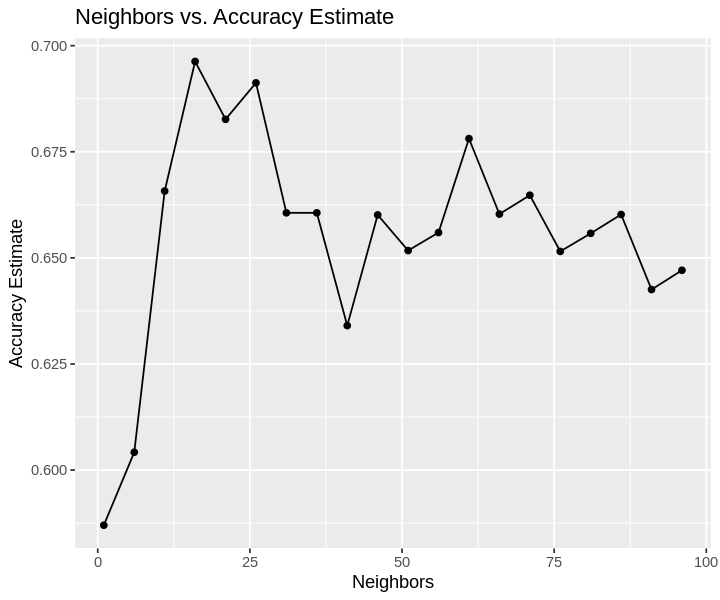

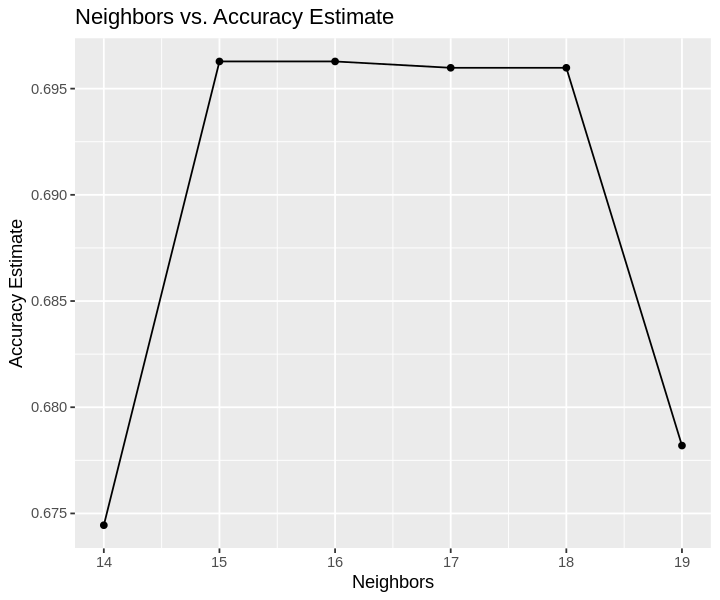

In [25]:
set.seed(1234) 

options(repr.plot.height = 5, repr.plot.width = 6)

heart_vfold <- vfold_cv(data = heart_data_training, v = 5, strata = heart_disease)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_recipe <- recipe(heart_disease ~ age + chol + trestbps + thalch + trestbps, data = heart_data_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

values_1 <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

heart_fit_1 <- workflow() |>
                add_model(knn_tune) |>
                add_recipe(heart_recipe) |>
                tune_grid(resamples = heart_vfold, grid = values_1) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

cross_val_plot_1 <- ggplot(heart_fit_1, aes(x = neighbors, y = mean)) + 
                    geom_point() + 
                    geom_line() + 
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    ggtitle("Neighbors vs. Accuracy Estimate")

cross_val_plot_1

values_2 <- tibble(neighbors = seq(from = 14, to = 19, by = 1))

heart_fit_2 <- workflow() |>
                add_model(knn_tune) |>
                add_recipe(heart_recipe) |>
                tune_grid(resamples = heart_vfold, grid = values_2) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

cross_val_plot_2 <- ggplot(heart_fit_2, aes(x = neighbors, y = mean)) + 
                    geom_point() + 
                    geom_line() + 
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    ggtitle("Neighbors vs. Accuracy Estimate")

cross_val_plot_2

- From the graph for the neighbors from 0 to 100, we can narrow down that the best k value with the highest accuracy is in the range of around 12 to 26.
- When we zoom in, we can see that the best K neighbors value is roughly 16.

In [26]:
set.seed(1234) 

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) |>
                set_engine("kknn") |>
                set_mode("classification")

heart_final_fit <- workflow() |>
            add_recipe(heart_recipe) |>
            add_model(heart_spec) |>
            fit(data = heart_data_training)

heart_final_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(16,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3303965
Best kernel: rectangular
Best k: 16

[1] "Accuracy of Model"


.metric  .estimator .estimate
1 accuracy binary     0.6623377

[1] "Recall of Model"


.metric .estimator .estimate
1 recall  binary     0.6

[1] "Precision of Model"


.metric   .estimator .estimate
1 precision binary     0.6363636

[1] "Matrix Table"


          Truth
Prediction absent present
   absent      30      14
   present     12      21

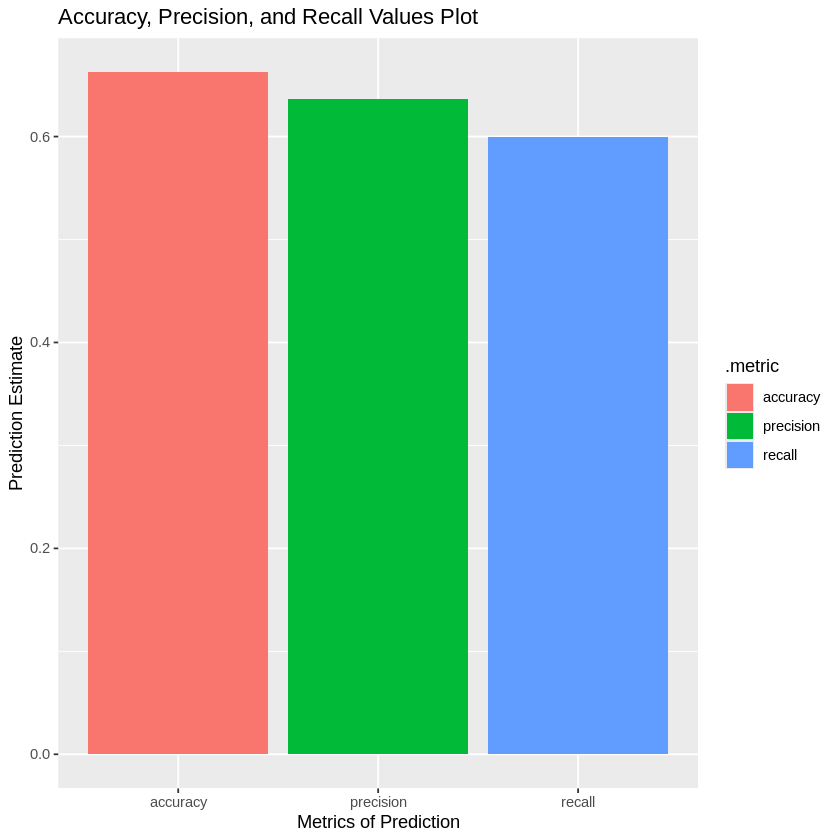

In [27]:
set.seed(1234)

heart_predictions <- heart_final_fit |>
    predict(heart_data_testing) |>
    bind_cols(heart_data_testing)

heart_conf_mat <- heart_predictions |>
    conf_mat(truth = heart_disease, estimate = .pred_class)

heart_metrics <- heart_predictions |>
    metrics(truth = heart_disease, estimate = .pred_class) |>
    filter(.metric == "accuracy")

print("Accuracy of Model")
heart_metrics

recall <- heart_predictions |>
    recall(truth = heart_disease, estimate = .pred_class, event_level = "second")
print("Recall of Model")
recall

precision <- heart_predictions |>
    precision(truth = heart_disease, estimate = .pred_class, event_level = "second")
print("Precision of Model")
precision

print("Matrix Table")
heart_conf_mat

merge <- bind_rows(heart_metrics, precision, recall) 

options(repr.plot.width = 7, repr.plot.height = 7)
metrics_bar_plot <- ggplot(merge, aes(x = .metric, y = .estimate, fill = .metric)) + 
                    geom_bar(stat = "identity") + 
                    labs(x = "Metrics of Prediction", y = "Prediction Estimate", color = "Metric of Prediction") + 
                    ggtitle("Accuracy, Precision, and Recall Values Plot")

metrics_bar_plot

- Our model has a 66.2% accuracy, which is not considered high. The recall, which is the number of correct positive predictions over the total positive observations, is 60%, also a relatively low percentage. For our model, the positive predictions are of the class “present”, and the negative predictions are of the class “absent”. With recall being low, this indicates that our model may not correctly diagnose patients who have heart disease, which might be fatal for people who actually have heart disease and were predicted in the class of “absent”.
  
- Our model has a precision of 63.6%, which is also not a very high percentage. However, this is not as fatal as having a lower recall percentage because it is less of an impact for someone without a heart to be diagnosed with heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


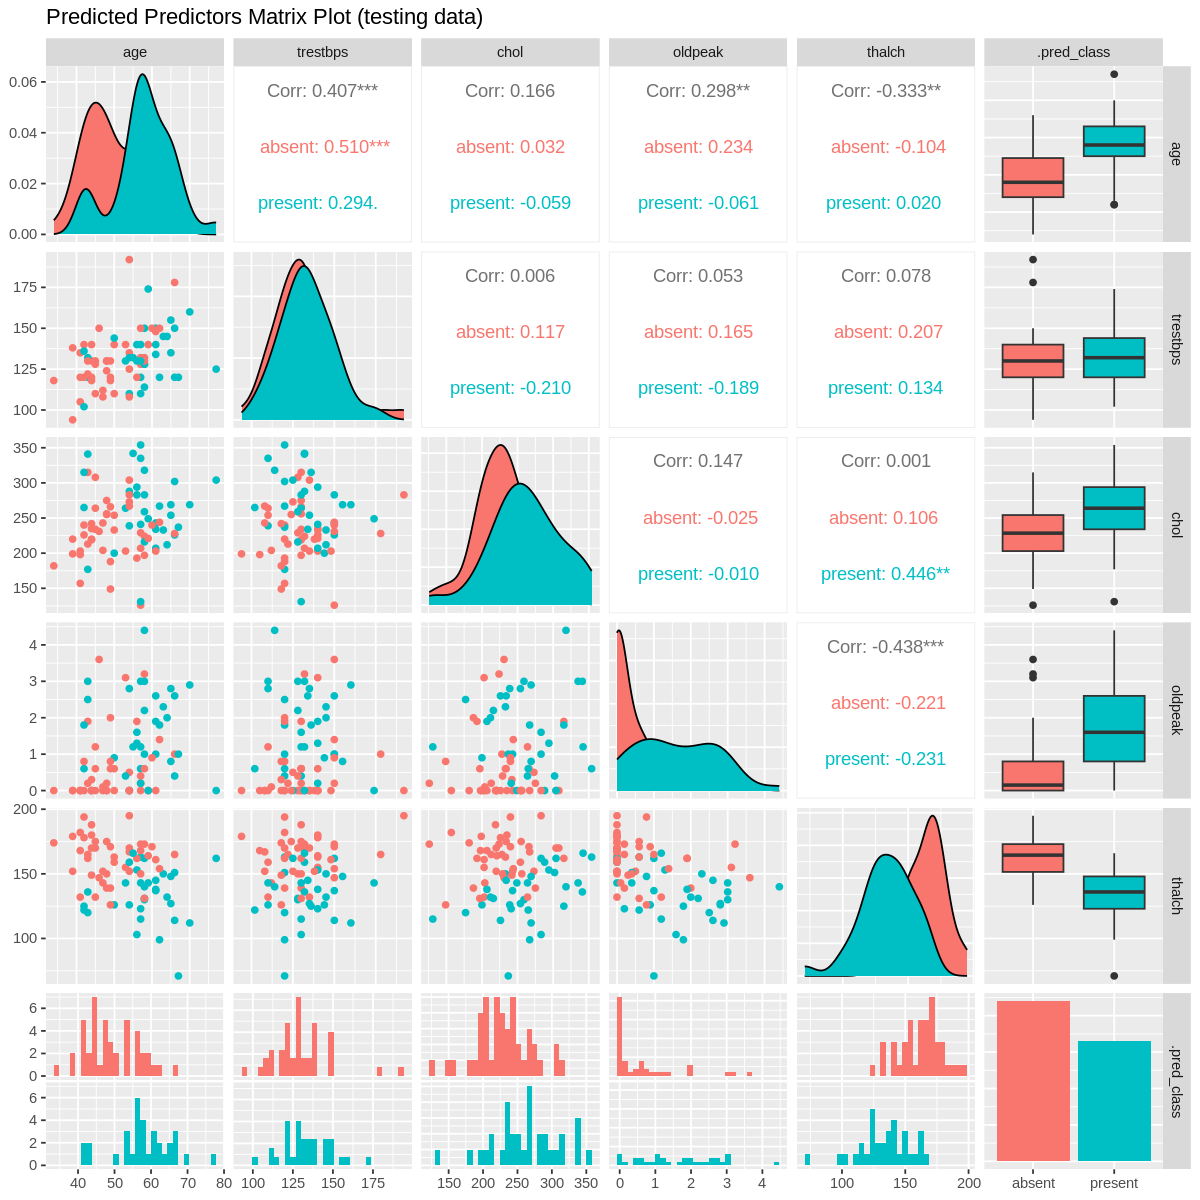

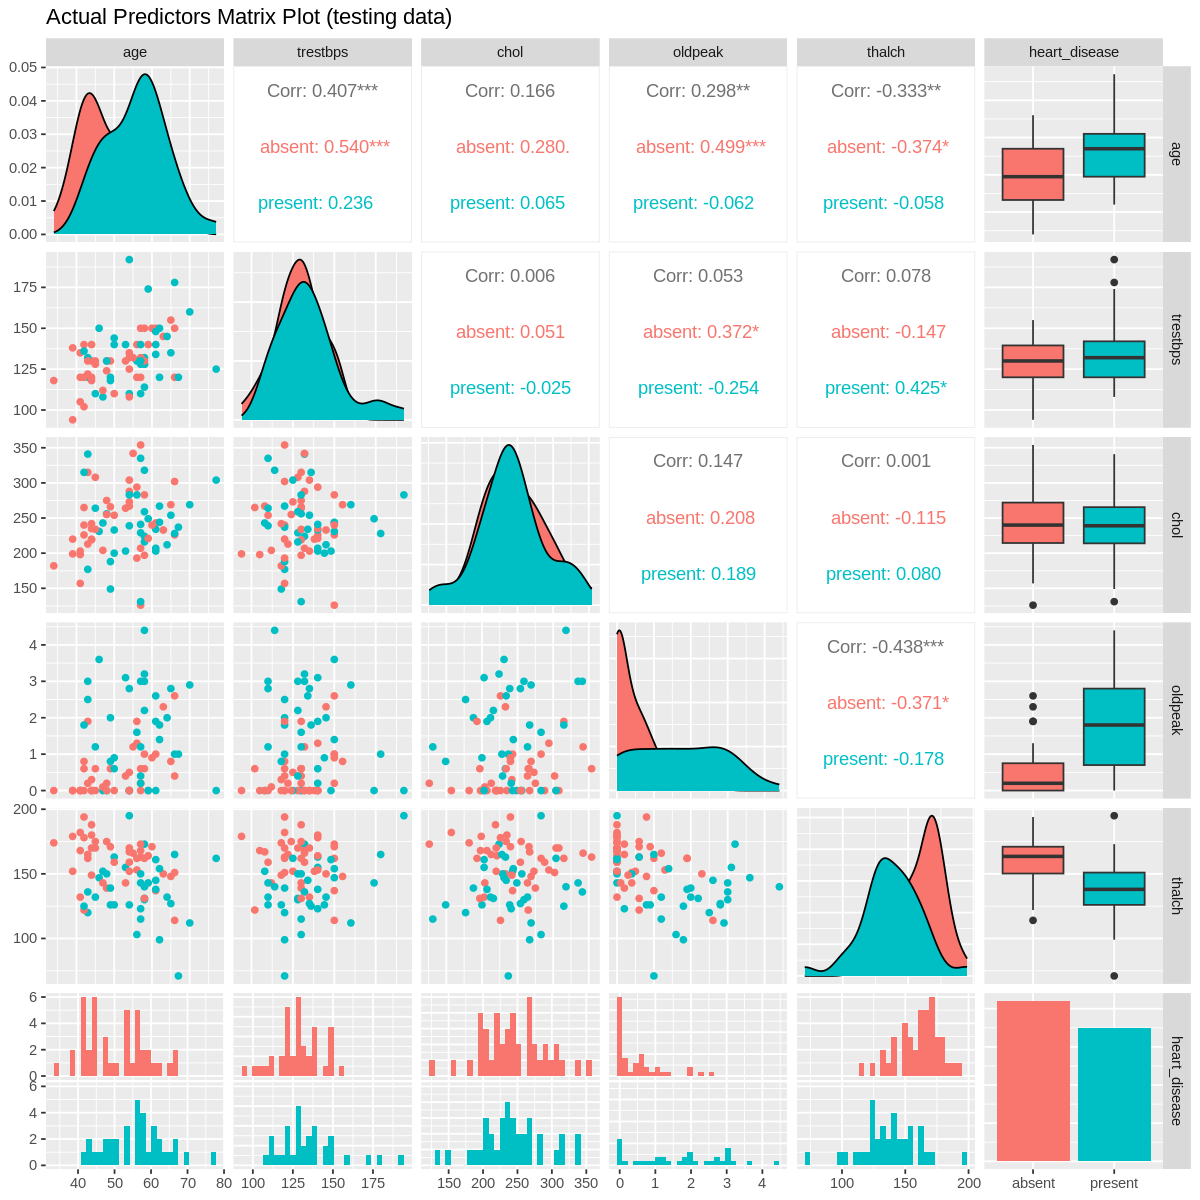

In [28]:
set.seed(1234)
options(repr.plot.width = 10, repr.plot.height = 10)

mnist_predictions_with_labels <- heart_predictions |> 
select(.pred_class) |>
bind_cols(heart_data_testing |> select (heart_disease)) |>
mutate(seq = 1:nrow(heart_predictions)) |>
as.data.frame()

predicted_labels <- mnist_predictions_with_labels |> select(.pred_class)

heart_testing_set <- bind_cols(heart_data_testing, predicted_labels)

#predicted diagnosis on testing data 
predicted_testing_diagnoses_plot <- heart_testing_set |> select(age, trestbps, chol, oldpeak, thalch, .pred_class) |> 
                                    ggpairs(mapping = aes(color = .pred_class)) +
                                    ggtitle("Predicted Predictors Matrix Plot (testing data)")
predicted_testing_diagnoses_plot

#actual diagnosis on testing data 
testing_diagnoses_plot <- heart_testing_set |> select(age, trestbps, chol, oldpeak, thalch, heart_disease) |> 
                          ggpairs(mapping = aes(color = heart_disease)) +
                        ggtitle("Actual Predictors Matrix Plot (testing data)")
testing_diagnoses_plot

- The first graph is the *predicted* diagnosis on our testing data and the second graph is the *actual* diagnosis on our testing data. We can see that the grouping and concentration for the present and absent classes for each predictor of the two matrix plots are similar. For example, if there are more blue points (present) concentrated in one area of the actual diagnosis graph, then there is a corresponding concentration of blue points in the same area in the predicted diagnosis graph. If there are more red points (absent) concentrated in one area of the actual diagnosis graph, then there are more red points in the same area in the predicted diagnosis graph. We can also see from our predicted diagnosis plot that it predicts more data points being absent than present for the testing data, which is shown on the bottom right bar plot. The points on the actual diagnosis graph are more mixed together while the predicted diagnosis graph tends to have more separations in between the blue and red.

### Discussion

- The accuracy rate at a lower percentage is not exactly what we expected to find. We expected the accuracy, recall, and precision to be higher with the five predictors to predict our model. The result shows that all of these three percentages are in the 60 to 70% range. This indicates that these predictors may not be as relevant to heart disease as we expected them to be. In order to increase accuracy.
  
- Since our model is not that accurate with 66.2% accuracy, the prediction of the “absent” and “present” classification of heart disease using our model is not accurate. Therefore, if we use this model in an actual prediction for patients’ heart disease, the inaccurate diagnosis will impact the patients both physically and mentally. If we want to use this model in the future, we need further investigations. For instance, we might consider other predictors other than the five predictors we are using now. This migh increase the accuracy and thereby create fewer negative impacts to the patients. We can also consider reducing the number of predictors to see whether we can have a better model. All of these will require further research since we need more background knowledge to filter out some of the existing predictors that are not as relevant, and choose the ones that are the most relevant.

- We can also consider the following questions for the future: 
1. Despite our model’s focus on Coronary Artery Heart Disease, can our model predict other heart diseases of the general public with the same predictors?
2. Which predictor is the most important in predicting Coronary Artery Heart Disease?
3. How does gender or regional differences contribute to the prediction of Coronary Artery Heart Disease?


#### References

- Detrano R, Janosi A, Steinbrunn W, Pfisterer M, Schmid JJ, Sandhu S, Guppy KH, Lee S, Froelicher V. International application of a new probability algorithm for the diagnosis of coronary artery disease. Am J Cardiol. 1989 Aug 1;64(5):304-10. doi: 10.1016/0002-9149(89)90524-9. PMID: 2756873. 

- Jacobsen, S. J., Freedman, D. S., Hoffmann, R. G., Gruchow, H. W., Anderson, A. J., & Barboriak, J. J. (1992). Cholesterol and coronary artery disease: Age as an effect modifier. Journal of Clinical Epidemiology, 45(10), 1053–1059. https://doi.org/10.1016/0895-4356(92)90145-d

- Strait, J. B., & Lakatta, E. G. (2012). Aging-associated cardiovascular changes and their relationship to heart failure. Heart Failure Clinics, 8(1), 143–164. https://doi.org/10.1016/j.hfc.2011.08.011 